In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

---
# A notebook to evaluate which voxels respond to the picture within the image in each conditions, and to evaluate spatial frequency tuning.
---
<a id='back_to_top'></a>

## Major sections
* [0. Preliminary Setup](#prim_setup)                       
* [1. Load the dataset](#load_data)  
* [2. Reload the models](#reload)
* [3. Create the feature spaces and generate model-space tensors](#create_mst)
* [4. Calculate the picture- and cue-related predictions](#prediction)
* [5. Tuning to spatial frequency](#tuning)
* [6. Overview of the prediction accuracy and tuning](#overview)

## Imports

In [2]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from glob import glob
import scipy.io as sio
from scipy import ndimage as nd
from scipy.stats import pearsonr
from scipy import misc
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
import PIL.Image as pim
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

import src.fwrf as fwrf
import src.feature_space as fs
import src.numpy_utility as pnu

from   src.plots import display_candidate_loss, plot_rf_as_circles   ## will need to be added to final repo
from   src.load_data import load_grayscale_stimuli, mask_grayscale_cue, load_zscored_voxels, load_voxels, split_mask
from   src.file_utility import load_mask_from_nii, view_data

fpX = fwrf.fpX

/usr/local/lib/python2.7/dist-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "


theano floatX: float32
numpy floatX: <type 'numpy.float32'>


Using cuDNN version 7605 on context None
Preallocating 7265/24217 Mb (0.300000) on cuda0
Mapped name None to device cuda0: TITAN RTX (0000:05:00.0)


## Global variables
### Subject and input directory

In [3]:
subject = 'TN'
subject_dir = 'TN_new/'
timestamp   = 'Dec-20-2019_1525' #'Dec-22-2019_1525' # # 'Dec-09-2019_1318' # 'Dec-18-2019_1711' #  #fwrf_TN_Dec-09-2019_1318_data

dataset_dir = "/home/styvesg/Documents/PostDoc/Datasets/imagery_rf/" + subject_dir
output_dir = os.getcwd() + '/output/' + subject_dir
print "Dataset dir: %s" % dataset_dir
print "Output dir : %s" % output_dir

Dataset dir: /home/styvesg/Documents/PostDoc/Datasets/imagery_rf/TN_new/
Output dir : /home/styvesg/Documents/PostDoc/GitRepo/imagery-clean/output/TN_new/


### Graphics global and print options

In [4]:
saveext = ".png"
savearg = {'format':'png', 'dpi': 300}

sns.axes_style()
sns.set_style("whitegrid", {"axes.facecolor": '.95'})
sns.set_context("notebook", rc={'axes.labelsize': 18.0, 'axes.titlesize': 24.0,\
    'legend.fontsize': 18.0, 'xtick.labelsize': 18.0, 'ytick.labelsize': 18.0})
sns.set_palette("deep")

<a id='load_data'></a>
# 1. Load the dataset 
## Load the image dataset
(the images that were presented to the subject for which we have voxel data)

[back to top](#back_to_top)

In [5]:
npx = 600 # resolution at which to load (600 is the native resolution for this dataset)
stim_data, stimuli_meta = load_grayscale_stimuli(dataset_dir, npx)
pic_data = mask_grayscale_cue(stim_data)

## Separate the pcp and img sets into matching presentation set

In [6]:
pcp_mask, img_mask = split_mask(stimuli_meta)

pcp_stim_data = stim_data[pcp_mask]
img_stim_data = stim_data[img_mask]

pcp_pic_data = pic_data[pcp_mask]
img_pic_data = pic_data[img_mask]

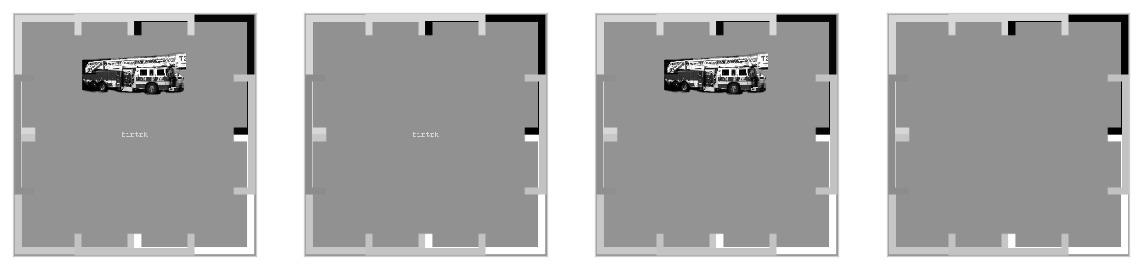

In [7]:
plt.figure(figsize=(20,5))
for k,i in enumerate([pcp_stim_data, img_stim_data, pcp_pic_data, img_pic_data]):
    plt.subplot(1,4,k+1)
    plt.imshow(i[0,0,:,:], cmap='gray')
    plt.grid(False)
    _=plt.xticks([])
    _=plt.yticks([])

<a id='reload'></a>
# 2. Reload the models

[back to top](#back_to_top)

In [8]:
data_file = open(output_dir + 'fwrf_%s_%s_data.pkl' % (subject, timestamp), 'rb')
models = pickle.load(data_file)
data_file.close()

pcp_models = models['pcp']
img_models = models['img']

project    = models['project']
subject    = models['subject']
voxel_mask = models['voxel_mask']
voxel_roi  = models['voxel_roi']
voxel_idx  = models['voxel_idx']
voxel_grid = models['voxel_grid']
roi_map    = models['roi_map']

In [9]:
print models.keys()

['tho_size', 'n_parts', 'voxel_roi', 'fmaps_count', 'roi_map', 'trn_size', 'lambda_params', 'mst_norm_avg', 'gabor_params', 'rf_models', 'subject', 'img', 'pcp', 'freq_rlist', 'env', 'aperture', 'val_size', 'ori_rlist', 'voxel_mask', 'voxel_idx', 'ori', 'freq', 'voxel_grid', 'fmaps_sizes', 'grid_size', 'mst_norm_std', 'project', 'grid_range', 'model_name']


## Load the corresponding voxel data

In [10]:
voxel_data,_ = load_voxels(dataset_dir)

pcp_voxel_data = voxel_data[pcp_mask][:,voxel_mask]
img_voxel_data = voxel_data[img_mask][:,voxel_mask]

nv = pcp_voxel_data.shape[1]
print "Full voxel count over all ROIs: %d" % nv

Full voxel count over all ROIs: 53204


## Display an arbitrary slice of the brain mask and ROIs

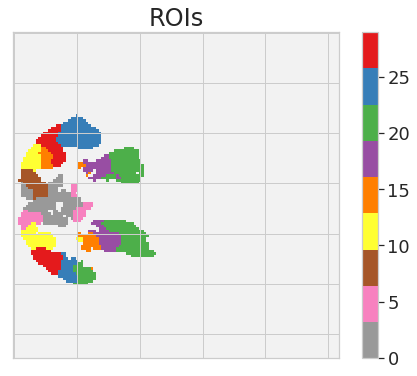

In [11]:
volume_roi = view_data(voxel_grid, voxel_idx, voxel_roi)

fig = plt.figure(figsize=(8,6))
plt.imshow(volume_roi[:,:,15], cmap='Set1_r', interpolation='None')
plt.colorbar()
plt.title('ROIs')
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])

<a id='create_mst'></a>
# 3. Create the feature spaces and generate model-space tensors
The model space tensor is a convenience intermediary point between the feature space and the model regression of the fwRF model. Calculating the model-space tensor explicitly once and for all results in more efficient modelling.

[back to top](#back_to_top)

In [12]:
gabor_params = models['gabor_params']
log_act_func = lambda x: np.log(1+np.sqrt(x))

In [13]:
pcp_stim_fmaps, freq, env, ori, freq_rlist, ori_rlist, fmaps_sizes, nf = fs.create_gabor_feature_maps(\
    pcp_stim_data, gabor_params=gabor_params, nonlinearity=log_act_func)
###
pcp_pic_fmaps, freq, env, ori, freq_rlist, ori_rlist, fmaps_sizes, nf = fs.create_gabor_feature_maps(\
    pcp_pic_data,  gabor_params=gabor_params, nonlinearity=log_act_func)
###
img_stim_fmaps, freq, env, ori, freq_rlist, ori_rlist, fmaps_sizes, nf = fs.create_gabor_feature_maps(\
    img_stim_data, gabor_params=gabor_params, nonlinearity=log_act_func)

{'pix_per_cycle': 4.13, 'deg_per_stimulus': 16.000002847402424, 'diams_per_filter': 4.0, 'num_sp_freq': 12, 'n_orientations': 4, 'cycles_per_radius': 1.0, 'n_colors': 1, 'complex_cell': True, 'highest_sp_freq': 11.0, 'lowest_sp_freq': 0.35}
allocating memory for feature maps
constructing feature maps
feature 0 took 0.181024 s.
feature 1 took 0.198294 s.
feature 2 took 0.216652 s.
feature 3 took 0.268663 s.
feature 4 took 0.288785 s.
feature 5 took 0.370114 s.
feature 6 took 0.534394 s.
feature 7 took 0.842900 s.
feature 8 took 1.330984 s.
feature 9 took 2.288126 s.
feature 10 took 3.992507 s.
feature 11 took 7.390424 s.
feature 12 took 0.174077 s.
feature 13 took 0.184522 s.
feature 14 took 0.198774 s.
feature 15 took 0.232935 s.
feature 16 took 0.290263 s.
feature 17 took 0.371084 s.
feature 18 took 0.530281 s.
feature 19 took 0.833520 s.
feature 20 took 1.366679 s.
feature 21 took 2.431354 s.
feature 22 took 4.042081 s.
feature 23 took 7.488409 s.
feature 24 took 0.179527 s.
feature 

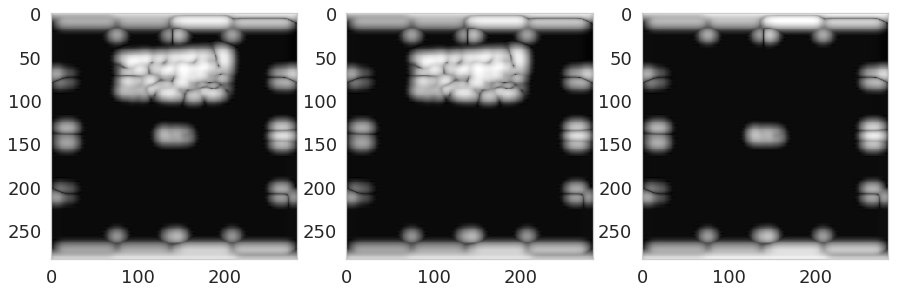

In [14]:
fig=plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(pcp_stim_fmaps[8][0,0,:,:], cmap='gray', interpolation='None')
plt.grid(False)
plt.subplot(1,3,2)
plt.imshow(pcp_pic_fmaps[8][0,0,:,:], cmap='gray', interpolation='None')
plt.grid(False)
plt.subplot(1,3,3)
plt.imshow(img_stim_fmaps[8][0,0,:,:], cmap='gray', interpolation='None')
plt.grid(False)

## Create the model-space tensor from the feature maps
Set the global hyperparameters of the receptive field candidate space and initialize parameters

In [15]:
aperture   = models['aperture']
nx, ny, ns = models['grid_size']
rx, ry, rs = models['grid_range']

pcp_mst_avg = models['mst_norm_avg']
pcp_mst_std = models['mst_norm_std']

model_specs = [[rx, ry, rs], [fwrf.linspace(nx), fwrf.linspace(ny), fwrf.logspace(ns)]]

rf_models = fwrf.model_space(model_specs)
print rf_models.shape

(5292, 3)


Imagery and vision runs share the same model-space tensors

In [16]:
pcp_mst_data,_,_ = fwrf.model_space_tensor(pcp_stim_fmaps,\
    rf_models, feature_envelopes=env, \
    nonlinearity=None, \
    zscore=True, mst_avg=pcp_mst_avg, mst_std=pcp_mst_std, trn_size=len(pcp_stim_data),\
    epsilon=1e-6, batches=(200, nx*ny), \
    view_angle=aperture, verbose=True, dry_run=False)
# rf_models, env, nonlinearity=None, \
#                zscore=True, trn_size=len(pcp_pic_data), epsilon=1e-6,\
#                batches=(512, nx*ny), view_angle=aperture, verbose=True, dry_run=False)
    
print pcp_mst_data.shape
print np.amin(pcp_mst_data), np.amax(pcp_mst_data)

CREATING SYMBOLS

> feature map candidates 0 with shape (1, 441, 23, 23)
> feature map candidates 1 with shape (1, 441, 32, 32)
> feature map candidates 2 with shape (1, 441, 43, 43)
> feature map candidates 3 with shape (1, 441, 59, 59)
> feature map candidates 4 with shape (1, 441, 81, 81)
> feature map candidates 5 with shape (1, 441, 111, 111)
> feature map candidates 6 with shape (1, 441, 152, 152)
> feature map candidates 7 with shape (1, 441, 207, 207)
> feature map candidates 8 with shape (1, 441, 284, 284)
> feature map candidates 9 with shape (1, 441, 388, 388)
> feature map candidates 10 with shape (1, 441, 531, 531)
> feature map candidates 11 with shape (1, 441, 727, 727)
  total number of feature maps = 48, in 12 layers
  feature map candidate using approx 1906.7 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 0.484Gb of RAM!
>> Will be divided in chunks of 0.040Gb of VRAM!

COMPILING...
1.41 seconds to compile theano functions

Preco

100%|██████████| 12/12 [04:14<00:00, 21.24s/it]

5292 mst candidate responses took 254.931s @ 20.759 models/s
Z-scoring modelspace tensor...
Using provided z-scoring values.



12it [00:00, 13.13it/s]


(512, 48, 1, 5292)
-22.46638 22.592089


# Sanity check of the model predictions

In [17]:
pcp_models = models['pcp']
img_models = models['img']

In [18]:
pp_val_pred = fwrf.kout_get_prediction_from_mst(pcp_mst_data, pcp_models, batches=(512, ns*ny*nx))
pi_val_pred = fwrf.kout_get_prediction_from_mst(pcp_mst_data, img_models, batches=(512, ns*ny*nx))
###
ppp_val_cc = fwrf.prediction_accuracy(pp_val_pred, pcp_voxel_data)
pii_val_cc = fwrf.prediction_accuracy(pi_val_pred, img_voxel_data)

100%|██████████| 53204/53204 [00:03<00:00, 14108.53it/s]


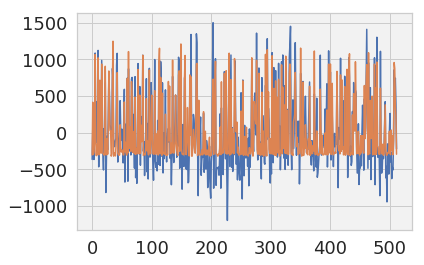

In [19]:
idx = np.argmax(np.nan_to_num(ppp_val_cc))
plt.plot(pcp_voxel_data[:,idx])
plt.plot(pp_val_pred[:,idx])

sum(cc>0.16) = 14390
sum(cc>0.16) = 5690


(-0.25, 1.0)

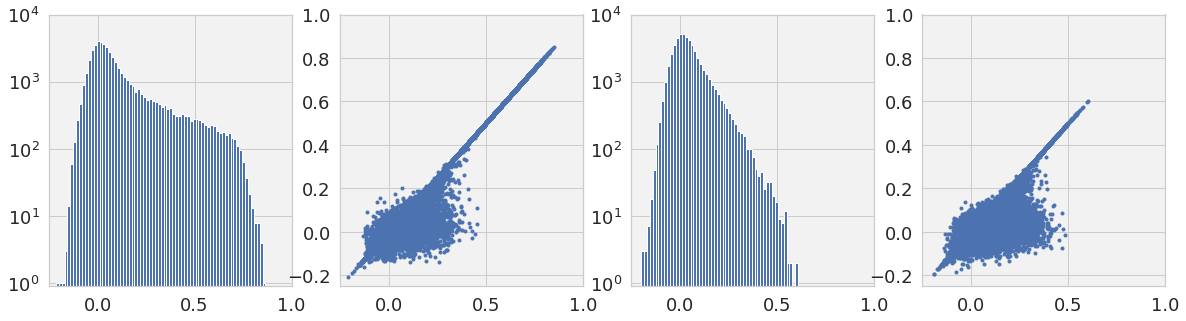

In [20]:
cc_th = 0.16
print "sum(cc>%.2f) = %d" % (cc_th, np.sum(map(lambda x: x > cc_th, ppp_val_cc)))
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
_=plt.hist(ppp_val_cc, bins=100, range=(-.5, 1.))
plt.yscale('log')
plt.xlim([-.25, 1.])
plt.ylim([9*10**-1, 10**4])
plt.subplot(1,4,2)
plt.plot(pcp_models['val_cc'], ppp_val_cc, '.')
plt.xlim([-.25, 1.])
plt.ylim([-.25, 1.])
print "sum(cc>%.2f) = %d" % (cc_th, np.sum(map(lambda x: x > cc_th, pii_val_cc)))
plt.subplot(1,4,3)
_=plt.hist(pii_val_cc, bins=100, range=(-.5, 1.))
plt.yscale('log')
plt.xlim([-.25, 1.])
plt.ylim([9*10**-1, 10**4])
plt.subplot(1,4,4)
plt.plot(img_models['val_cc'], pii_val_cc, '.')
plt.xlim([-.25, 1.])
plt.ylim([-.25, 1.])

## cuDNN vs cuda

In [21]:
data_file = open(output_dir + 'temp_TN_Dec-20-2019_1525.pkl', 'rb')
cudnn_cc = pickle.load(data_file)
data_file.close()

(-0.25, 1.0)

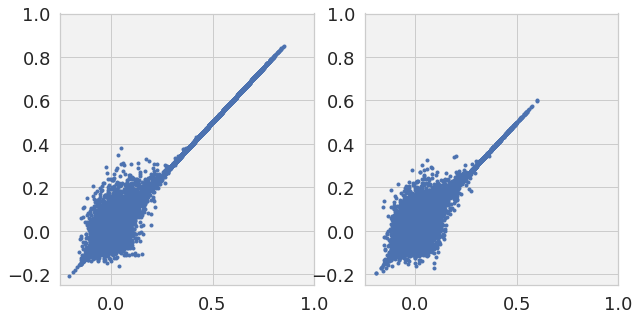

In [23]:
fig1=plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(cudnn_cc['ppp_val_cc'], ppp_val_cc, '.')
plt.xlim([-.25, 1.])
plt.ylim([-.25, 1.])
plt.subplot(1,2,2)
plt.plot(cudnn_cc['pii_val_cc'], pii_val_cc, '.')
plt.xlim([-.25, 1.])
plt.ylim([-.25, 1.])

In [24]:
filename = output_dir + "inconsistencies_between_cuda_and_cudnn_%s%s" % (subject, saveext)
fig1.patch.set_alpha(0.)
fig1.savefig(filename, **savearg)
plt.close()

In [22]:
***
mask_file_name = output_dir + "temp_%s_%s.pkl" % (subject, timestamp)
mask_values = {
               'ppp_val_cc': ppp_val_cc,
               'pii_val_cc': pii_val_cc
              }
mask_file = open(mask_file_name, 'wb')
pickle.dump(mask_values, mask_file)
mask_file.close()

# Calculate model cross-validation accuracy

### Does the imagery encoding model provide some unique information of imagery activity?

In [30]:
pic_mst_data,_,_ = fwrf.model_space_tensor(pcp_pic_fmaps, rf_models, env, nonlinearity=None, \
                zscore=True, mst_avg=pcp_mst_avg, mst_std=pcp_mst_std, trn_size=len(pcp_pic_data), epsilon=1e-6,\
                batches=(512, nx*ny), view_angle=aperture, verbose=True, dry_run=False)

cue_mst_data,_,_ = fwrf.model_space_tensor(img_stim_fmaps, rf_models, env, nonlinearity=None, \
                zscore=True, mst_avg=pcp_mst_avg, mst_std=pcp_mst_std, trn_size=len(img_stim_data), epsilon=1e-6,\
                batches=(512, nx*ny), view_angle=aperture, verbose=True, dry_run=False)

CREATING SYMBOLS

> feature map candidates 0 with shape (1, 441, 23, 23)
> feature map candidates 1 with shape (1, 441, 32, 32)
> feature map candidates 2 with shape (1, 441, 43, 43)
> feature map candidates 3 with shape (1, 441, 59, 59)
> feature map candidates 4 with shape (1, 441, 81, 81)
> feature map candidates 5 with shape (1, 441, 111, 111)
> feature map candidates 6 with shape (1, 441, 152, 152)
> feature map candidates 7 with shape (1, 441, 207, 207)
> feature map candidates 8 with shape (1, 441, 284, 284)
> feature map candidates 9 with shape (1, 441, 388, 388)
> feature map candidates 10 with shape (1, 441, 531, 531)
> feature map candidates 11 with shape (1, 441, 727, 727)
  total number of feature maps = 48, in 12 layers
  feature map candidate using approx 1906.7 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 0.484Gb of RAM!
>> Will be divided in chunks of 0.040Gb of VRAM!

COMPILING...
0.85 seconds to compile theano functions

Preco

100%|██████████| 12/12 [04:14<00:00, 21.22s/it]

5292 mst candidate responses took 254.686s @ 20.779 models/s
Z-scoring modelspace tensor...
Using provided z-scoring values.



12it [00:00, 12.46it/s]


CREATING SYMBOLS

> feature map candidates 0 with shape (1, 441, 23, 23)
> feature map candidates 1 with shape (1, 441, 32, 32)
> feature map candidates 2 with shape (1, 441, 43, 43)
> feature map candidates 3 with shape (1, 441, 59, 59)
> feature map candidates 4 with shape (1, 441, 81, 81)
> feature map candidates 5 with shape (1, 441, 111, 111)
> feature map candidates 6 with shape (1, 441, 152, 152)
> feature map candidates 7 with shape (1, 441, 207, 207)
> feature map candidates 8 with shape (1, 441, 284, 284)
> feature map candidates 9 with shape (1, 441, 388, 388)
> feature map candidates 10 with shape (1, 441, 531, 531)
> feature map candidates 11 with shape (1, 441, 727, 727)
  total number of feature maps = 48, in 12 layers
  feature map candidate using approx 1906.7 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 0.484Gb of RAM!
>> Will be divided in chunks of 0.040Gb of VRAM!

COMPILING...
0.87 seconds to compile theano functions

Preco

100%|██████████| 12/12 [04:15<00:00, 21.25s/it]

5292 mst candidate responses took 255.020s @ 20.751 models/s
Z-scoring modelspace tensor...
Using provided z-scoring values.



12it [00:00, 12.45it/s]


In [31]:
kp_val_pred = fwrf.kout_get_prediction_from_mst(pic_mst_data, pcp_models, batches=(512, ns*ny*nx))
ki_val_pred = fwrf.kout_get_prediction_from_mst(pic_mst_data, img_models, batches=(512, ns*ny*nx))
###
kpp_val_cc = fwrf.prediction_accuracy(kp_val_pred, pcp_voxel_data)
kii_val_cc = fwrf.prediction_accuracy(ki_val_pred, img_voxel_data)
kpi_val_cc = fwrf.prediction_accuracy(kp_val_pred, img_voxel_data)
kip_val_cc = fwrf.prediction_accuracy(ki_val_pred, pcp_voxel_data)

100%|██████████| 399430/399430 [00:31<00:00, 12593.69it/s]


Text(0,0.5,'img model predicts img')

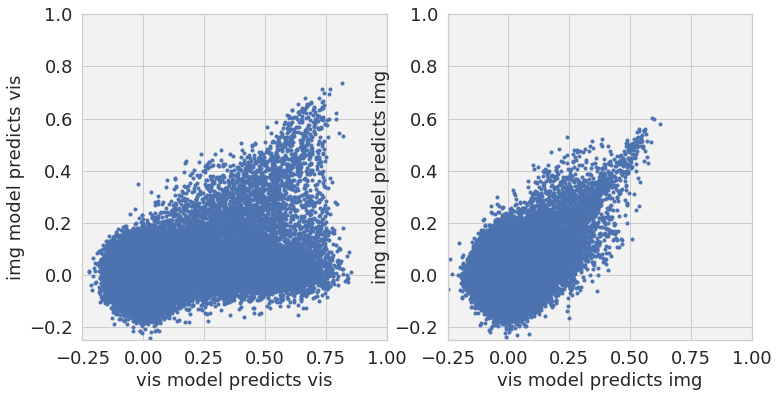

In [32]:
cc_th = 0.16
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(kpp_val_cc, kip_val_cc, '.')
plt.xlim([-.25, 1.])
plt.ylim([-.25, 1.])
plt.xlabel('vis model predicts vis')
plt.ylabel('img model predicts vis')
###
plt.subplot(1,2,2)
plt.plot(kpi_val_cc, kii_val_cc, '.')
plt.xlim([-.25, 1.])
plt.ylim([-.25, 1.])
plt.xlabel('vis model predicts img')
plt.ylabel('img model predicts img')

<a id='prediction'></a>
# 4. Calculate the picture- and cue-related predictions

[back to top](#back_to_top)

## Prediction accuracies for the picture only and cue only stimuli

In [33]:
cp_val_pred = fwrf.kout_get_prediction_from_mst(cue_mst_data, pcp_models, batches=(512, ns*ny*nx))
ci_val_pred = fwrf.kout_get_prediction_from_mst(cue_mst_data, img_models, batches=(512, ns*ny*nx))
###
cpp_val_cc = fwrf.prediction_accuracy(cp_val_pred, pcp_voxel_data)
cii_val_cc = fwrf.prediction_accuracy(ci_val_pred, img_voxel_data)

100%|██████████| 399430/399430 [00:31<00:00, 12837.25it/s]


## Estimate average vision and imagery receptive field position and sizes

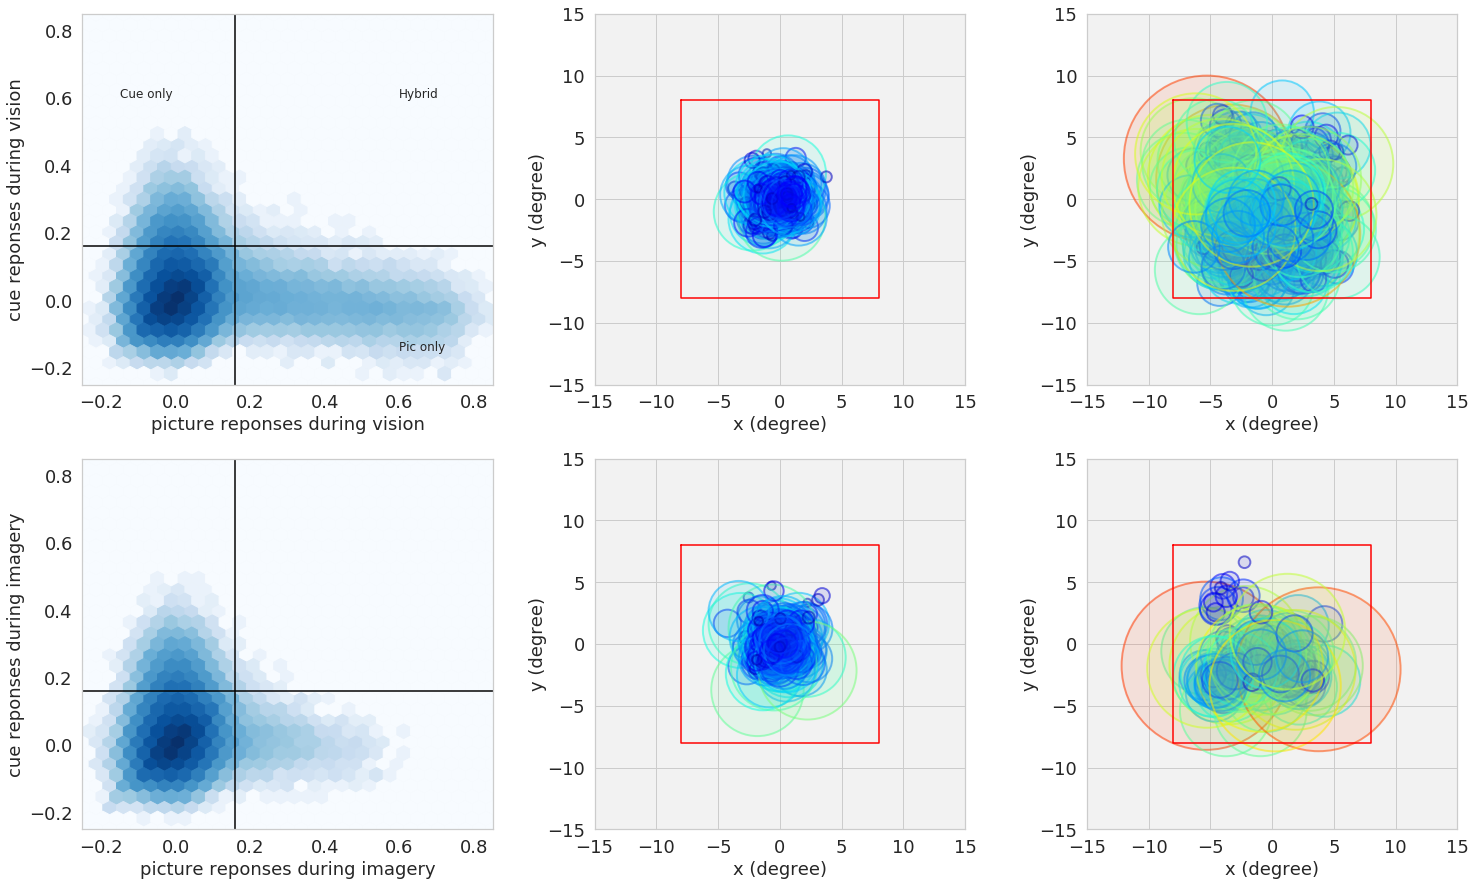

In [34]:
from src.plots import plot_joint_cc_and_cue_and_picture_rf
fig=plt.figure(figsize=(25,15))
plot_joint_cc_and_cue_and_picture_rf(\
    pcp_models, kpp_val_cc, cpp_val_cc,\
    img_models, kii_val_cc, cii_val_cc,\
    xlim=[-.25, 0.85], ylim=[-.25, 0.85], view_angle=aperture, threshold=0.16, frac_prune=0.95)

In [35]:
mask_file_name = output_dir + "fwrf_%s_%s_mask.pkl" % (subject, timestamp)
mask_values = {
               'kpi_val_cc': kpi_val_cc,
               'kip_val_cc': kip_val_cc,
               'pic_pcp_val_cc': kpp_val_cc,
               'cue_pcp_val_cc': cpp_val_cc,
               'pic_img_val_cc': kii_val_cc,
               'cue_img_val_cc': cii_val_cc,
               'pic_pcp_pred': kp_val_pred,
               'pic_img_pred': ki_val_pred
              }
mask_file = open(mask_file_name, 'wb')
pickle.dump(mask_values, mask_file)
mask_file.close()
print mask_file_name

/home/styvesg/Documents/PostDoc/GitRepo/imagery-clean/output/TN_new/fwrf_TN_Dec-22-2019_1525_mask.pkl


# Voxel masks

In [36]:
from src.analysis import _or, _and
mask_dicts = {}   
mask_dicts['pic_pcp'] = pic_pcp_mask = np.nan_to_num(kpp_val_cc)>cc_th
mask_dicts['pic_img'] = pic_img_mask = np.nan_to_num(kii_val_cc)>cc_th
mask_dicts['cue_pcp'] = cue_pcp_mask = np.nan_to_num(cpp_val_cc)>cc_th
mask_dicts['cue_img'] = cue_img_mask = np.nan_to_num(cii_val_cc)>cc_th
    
mask_dicts['cue'] = cue_mask = _and(_and(cue_pcp_mask, cue_img_mask), ~_or(pic_pcp_mask, pic_img_mask)) # purple
mask_dicts['straggler'] = straggler_mask = _and(_or(cue_pcp_mask, cue_img_mask), ~_or(cue_mask, _or(pic_pcp_mask, pic_img_mask))) # magenta
mask_dicts['hybrid'] = hybrid_mask = _and(_or(cue_pcp_mask, cue_img_mask), _or(pic_pcp_mask, pic_img_mask)) # red
   
mask_dicts['pic'] = pic_mask = _and(_and(pic_pcp_mask, pic_img_mask), ~hybrid_mask) #green
mask_dicts['pcp'] = pcp_mask = _or(_and(pic_pcp_mask, ~hybrid_mask), pic_mask) #blue+green
mask_dicts['img'] = img_mask = _or(_and(pic_img_mask, ~hybrid_mask), pic_mask) #yellow+green

mask_dicts['pcp_xcl'] = _and(_and(pic_pcp_mask, ~pic_mask), ~hybrid_mask) #blue
mask_dicts['img_xcl'] = _and(_and(pic_img_mask, ~pic_mask), ~hybrid_mask) #yellow
mask_dicts['none'] = ~_or(_or(pic_pcp_mask, pic_img_mask), _or(cue_pcp_mask, cue_img_mask)) #gray
mask_dicts['noncue'] = _and(~cue_mask, ~straggler_mask)

# Voxel ROI

In [37]:
roi_group_names = ['V1', 'V2', 'V3', 'V3a/b', 'V4', 'LO', 'IPS', 'ventral other', 'dorsal other']
roi_groups = [[0,1,2,3], [4,5,6,7], [8,9,10,11], [30,31,32,33], [12,13], [26,27,28,29], [34,35,36,37,38,39,40,41,42,43,44,45], [14,15,16,17,18,19,20,21],[22,23,24,25,46,47]]

from src.analysis import iterate_roi
coverage = np.zeros_like(pcp_models['val_cc']).astype(bool)
for roi, value  in enumerate(iterate_roi(roi_groups, voxel_roi, roi_map)):          
    roi_mask, name = value
    coverage = np.logical_or(coverage, roi_mask)
    print name, ',', np.sum(roi_mask)
print np.sum(coverage), '/', nv

V1v_L-V1v_R-V1d_L-V1d_R , 3567
V2v_L-V2v_R-V2d_L-V2d_R , 4371
V3v_L-V3v_R-V3d_L-V3d_R , 4527
V3b_L-V3b_R-V3a_L-V3a_R , 1970
hV4_L-hV4_R , 3305
LO_L_null-LO_R_null-LO_L-LO_R , 3610
IPS0_L-IPS0_R-IPS1_L-IPS1_R-IPS2_L-IPS2_R-IPS3_L-IPS3_R-IPS4_L-IPS4_R-IPS5_L-IPS5_R , 15172
VO1_L-VO1_R-VO2_L-VO2_R-PHC1_L-PHC1_R-PHC2_L-PHC2_R , 6534
MST_L-MST_R-hMT_L-hMT_R-SPL1_L-SPL1_R , 10148
53204 / 399430


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


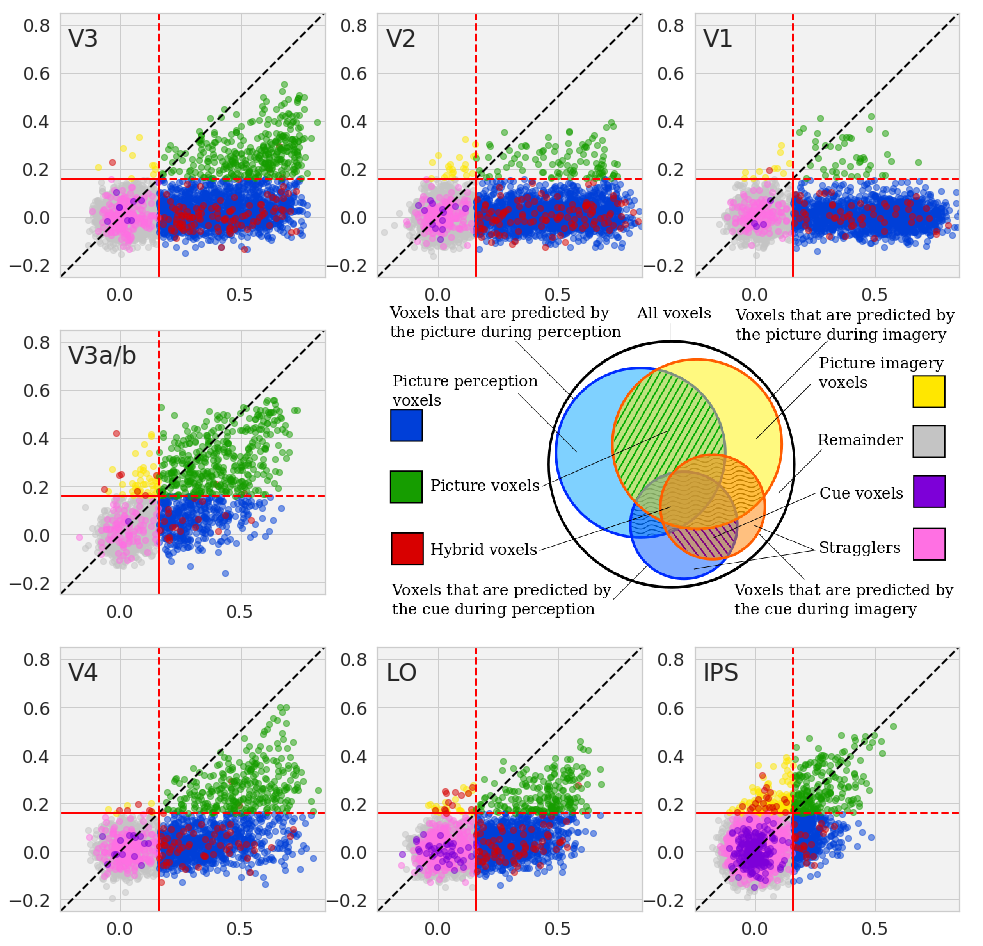

In [38]:
venn_diag = nd.imread('/home/styvesg/Documents/PostDoc/GitRepo/imagery-clean/analysis_voxel_supports.png')
from src.plots import set_detailed_roi_layout, plot_venn_voxels

xlim, ylim = [-0.25, 0.85], [-0.25, 0.85]
fig, roi_ax, ax_im, ax_mask = set_detailed_roi_layout()
ax_im.set_position([0.4, 0.24, .5, .5])
ax_im.imshow(venn_diag)

for roi, value  in enumerate(iterate_roi(roi_groups[:7], voxel_roi, roi_map)):          
    roi_mask, name = value
    ax = roi_ax[roi]
    plot_venn_voxels(ax,\
        kpp_val_cc, kii_val_cc,\
        roi_mask, mask_dicts['pic_pcp'], mask_dicts['pic_img'],\
        mask_dicts['cue_pcp'], mask_dicts['cue_img'],\
        cc_th, xlim, ylim)
    ax.set_aspect('equal')
    #ax.text(-0.15, .75, gn[roi], ha='left', fontsize=18, weight='bold')
    ax.set_title(roi_group_names[roi], position=(0.03, 0.85), ha='left')  

# ROI-wise, picture only cross validation

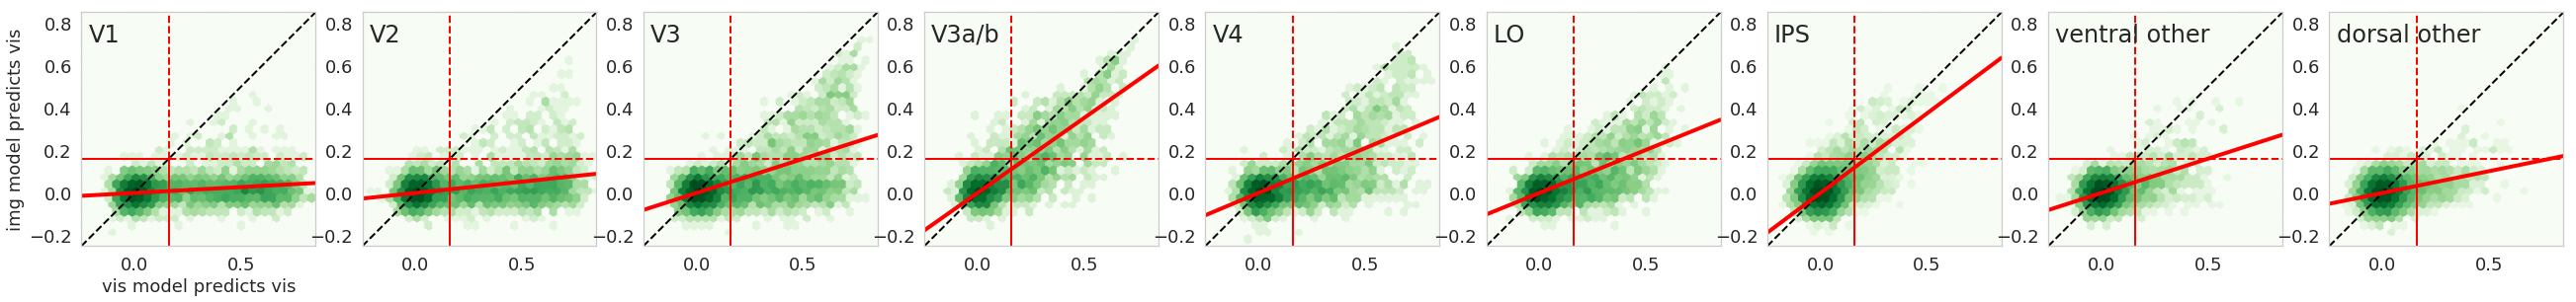

In [39]:
xlim, ylim = [-0.25, 0.85], [-0.25, 0.85]
from src.plots import pretty_accuracy_plot

cc_mask = mask_dicts['noncue']
good_mask = _and(cc_mask, ~mask_dicts['none'])
fig1=plt.figure(figsize=(5*len(roi_groups), 5))
for roi, value  in enumerate(iterate_roi(roi_groups, voxel_roi, roi_map)):          
    roi_mask, name = value
    plt.subplot(1,len(roi_groups),roi+1)
    ax = plt.gca()
    pretty_accuracy_plot(kpp_val_cc, kip_val_cc, \
        _and(cc_mask, roi_mask), _and(good_mask, roi_mask), cc_th, xlim, ylim)    
    ax.set_aspect('equal')
    ax.set_title(roi_group_names[roi], position=(0.03, 0.85), ha='left')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if roi==0:
        plt.xlabel('vis model predicts vis')
        plt.ylabel('img model predicts vis')

In [ ]:
filename = output_dir + "%s_per_roi_cross_validation_vis%s" % (subject, saveext)
fig1.patch.set_alpha(0.)
fig1.savefig(filename, **savearg)
plt.close()

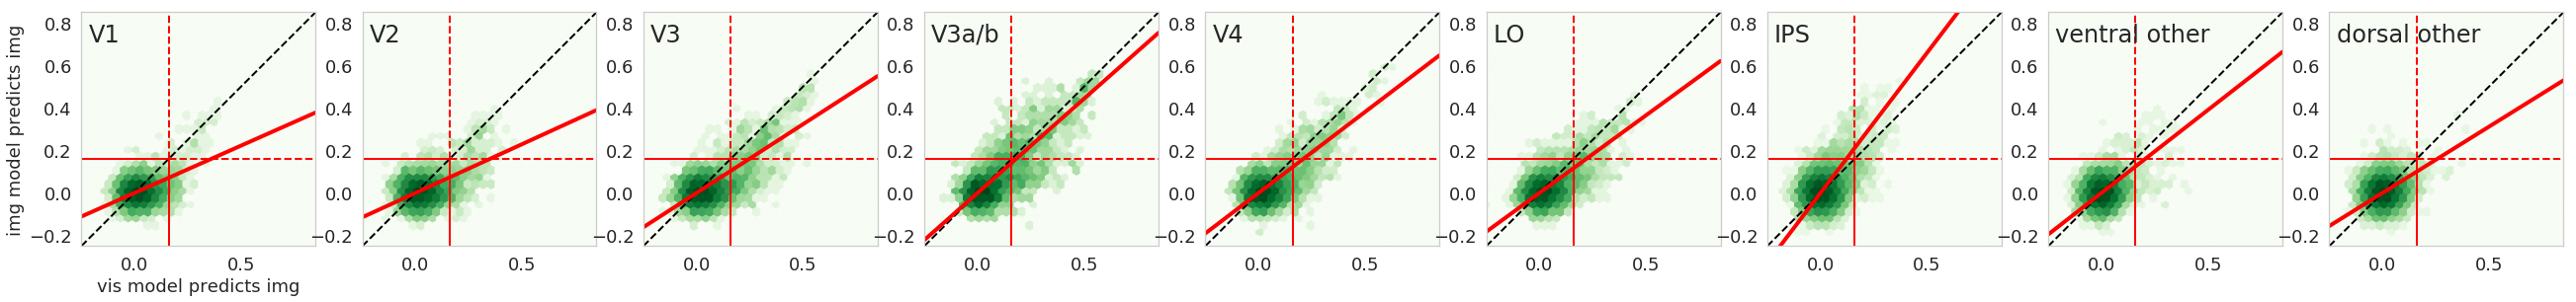

In [40]:
xlim, ylim = [-0.25, 0.85], [-0.25, 0.85]
from src.plots import pretty_accuracy_plot

cc_mask = mask_dicts['noncue']
good_mask = _and(cc_mask, ~mask_dicts['none'])
fig2=plt.figure(figsize=(5*len(roi_groups), 5))
for roi, value  in enumerate(iterate_roi(roi_groups, voxel_roi, roi_map)):          
    roi_mask, name = value
    plt.subplot(1,len(roi_groups),roi+1)
    ax = plt.gca()
    
    pretty_accuracy_plot(kpi_val_cc, kii_val_cc, \
        _and(cc_mask, roi_mask), _and(good_mask, roi_mask), cc_th, xlim, ylim)    
        
    #plt.plot(kpp_val_cc[roi_mask], kip_val_cc[roi_mask], '.')    
    #plt.plot(xlim, ylim, '--r')
    ax.set_aspect('equal')
    ax.set_title(roi_group_names[roi], position=(0.03, 0.85), ha='left')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if roi==0:
        plt.xlabel('vis model predicts img')
        plt.ylabel('img model predicts img')

In [ ]:
filename = output_dir + "%s_per_roi_cross_validation_img%s" % (subject, saveext)
fig2.patch.set_alpha(0.)
fig2.savefig(filename, **savearg)
plt.close()

<a id='tuning'></a>
# 5. Tuning to spatial frequency

[back to top](#back_to_top)

In [35]:
n_samples = 16

voxels = {'img': img_voxel_data,
          'pcp': pcp_voxel_data}

part_values = {'project': models['project'],
               'subject': models['subject'],
               'model_name': models['model_name'],
               'freq': freq}

for i,run in enumerate(voxels.keys()):
    # calculate a set of prediction based on subsets of the features    
    print "##########################################################"
    print "###          Get partial predictions for %s         ###" % run
    print "##########################################################"
    partition_val_pred = fwrf.kout_get_partial_predictions_from_mst(models[run], pic_mst_data, freq_rlist)
    # calculate the covariances of the subset (with sampling with replacement of the k-out models to estimate variance)
    part_values[run] = fwrf.relative_covariance(models[run], partition_val_pred, voxels[run], n_samples)

  0%|          | 0/16 [00:00<?, ?it/s]

##########################################################
###          Get partial predictions for pcp         ###
##########################################################


100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

##########################################################
###           Resampling with replacement              ###
##########################################################



  0%|          | 0/16 [00:00<?, ?it/s]

##########################################################
###          Get partial predictions for img         ###
##########################################################


100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

##########################################################
###           Resampling with replacement              ###
##########################################################



100%|██████████| 16/16 [09:32<00:00, 35.80s/it]


In [36]:
from src.file_utility import save_stuff
from src.load_data import flatten_dict
part_file_name = output_dir + "fwrf_%s_%s_part" % (subject, timestamp)
save_stuff(part_file_name, flatten_dict(part_values))
print part_file_name

saved project in h5py file
saved pcp.val_cc in h5py file
saved pcp.val_rc in h5py file
saved img.val_cc in h5py file
saved img.val_rc in h5py file
saved pcp.val_ri in h5py file
saved freq in h5py file
saved img.val_ri in h5py file
saved model_name in h5py file
saved subject in h5py file
/home/styvesg/Documents/PostDoc/GitRepo/imagery-clean/output/LF_new/fwrf_LF_Dec-19-2019_2238_part


<a id='overview'></a>
# 6. Overview of the prediction accuracy and tuning

[back to top](#back_to_top)

## Calculate the voxel-wise and ROI-wise spatial frequency tuning

In [37]:
from src.analysis import evaluate_tuning, evaluate_roi_tuning
from src.plots import plot_sorted_validation_accuracy, plot_voxel_tuning_samples, plot_roi_tuning_curves

# evaluate voxel-wise tuning curve for 'pcp' and 'img' based on the sampled partial prediction accuracy.
tuning_dicts = evaluate_tuning(models, part_values, voxels.keys())

# evaluate the ROI-wide tuning curve based on the previous voxel-wise tuning curves.
tuning_dicts = evaluate_roi_tuning(tuning_dicts, mask_dicts, voxels.keys(), roi_groups, voxel_roi, roi_map)

## Plot of the sorted validation accuracy (and s.d.) for all the voxels. 
Unsurprisingly, voxels with high prediction accuracy are also robust (have low s.d.).

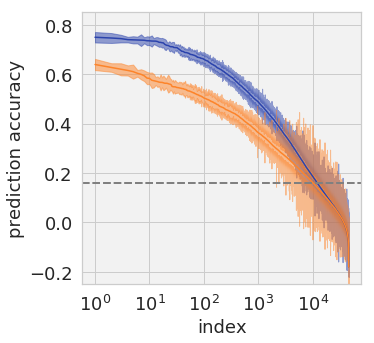

In [38]:
fig = plt.figure(figsize=(5, 5))
plot_sorted_validation_accuracy(tuning_dicts, voxels.keys(), cc_th)

## Plot for selected voxel indices that shows the raw sample spatial frequency tuning

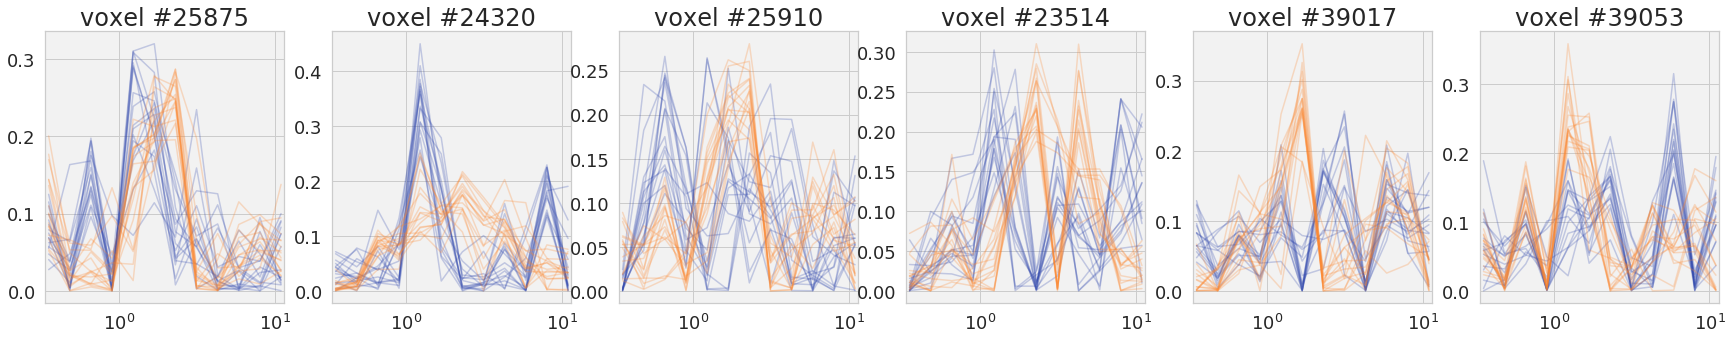

In [39]:
idxs = tuning_dicts['img']['idx_sorted'][:6]

plt.figure(figsize=(5*len(idxs),5))
plot_voxel_tuning_samples(freq, tuning_dicts, voxels.keys(), idxs)

## Plot the ROI spatial frequency tuning with fitted log-gaussian function

In [49]:
import src.plots as aaa
reload(aaa)
from src.plots import plot_sorted_validation_accuracy, plot_voxel_tuning_samples, plot_roi_tuning_curves

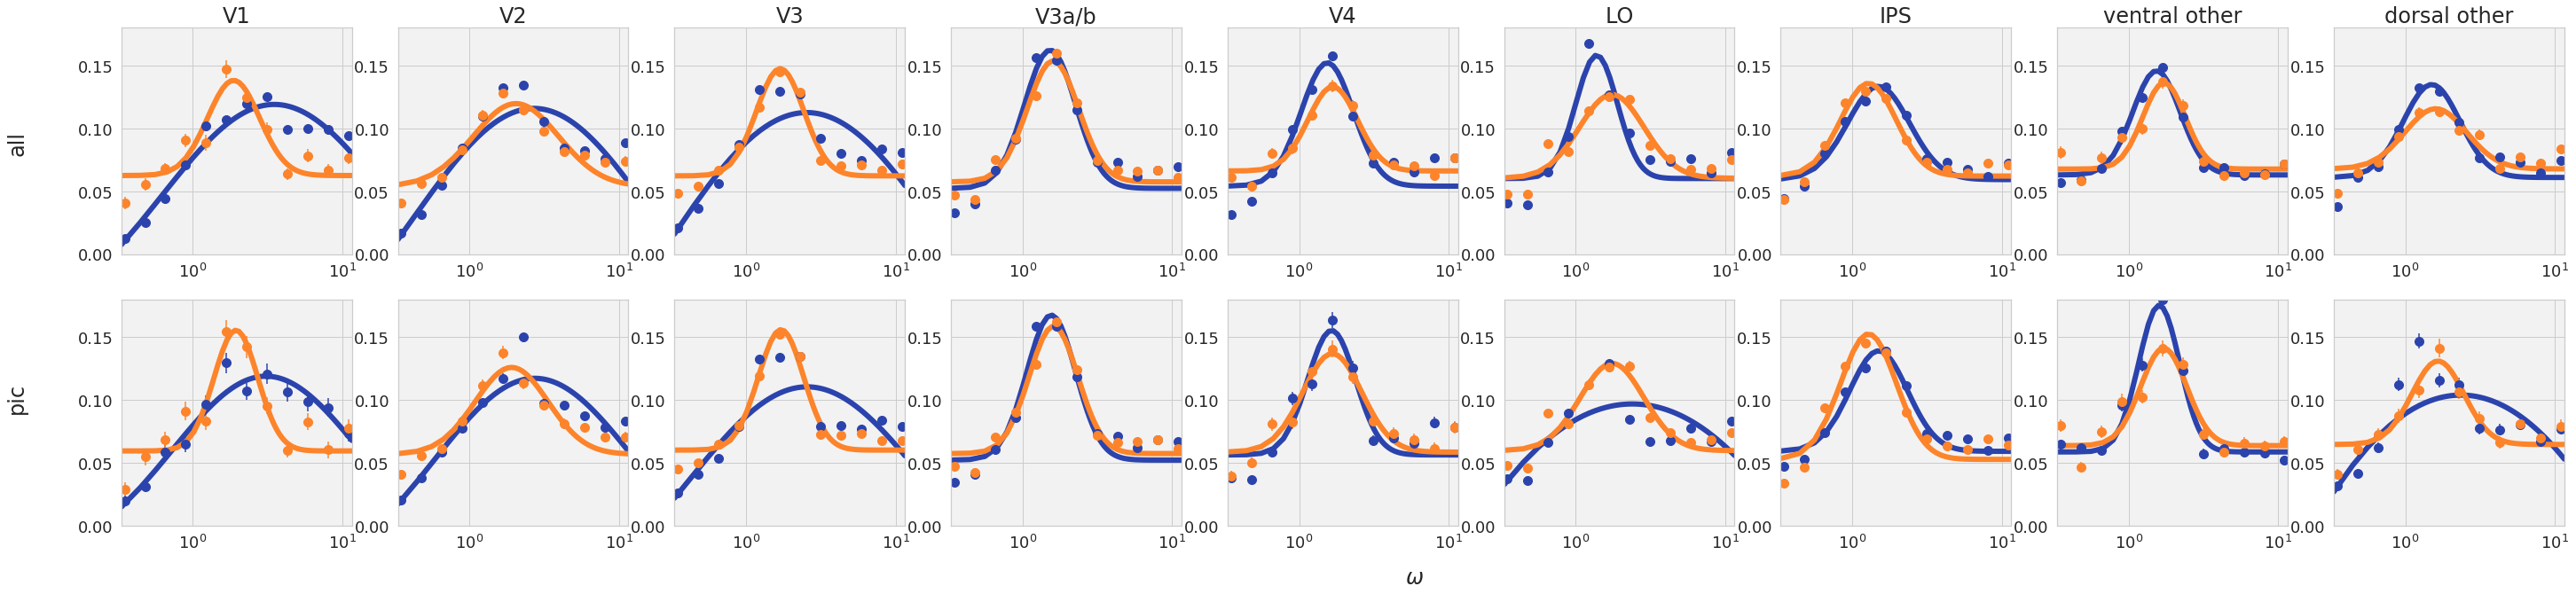

In [50]:
fig = plt.figure(figsize=(5*len(roi_groups),10))
plot_roi_tuning_curves(freq, tuning_dicts, voxels.keys(), roi_group_names)

[back to top](#back_to_top)